# The search for dark vessels: AIS / ship detection fusion workflow

All ships above a certain size are by law required to use an AIS (Automated Identification System) transponder and
are therefore trackable at all times wherever they go. A ship without such a signal is called a "dark vessel". While
there are not always sinister reasons for this behaviour this quite often indicates that something "fishy" is going
on. Not surprisingly there are many organisations which are interested in this kind of information.

In the following we show how dark vessels can be identified by combining a Machine Learning-based algorithm working on
satellite images (provided by Airbus, see https://marketplace.up42.com/block/79e3e48c-d65f-4528-a6d4-e8d20fecc93c for more details) with AIS signals (provided by ExactEarth; see https://marketplace.up42.com/block/54217695-73f4-4528-a575-a429e9af6568).

The workflow consists of the following steps:

- Get SPOT imagery for the given AOI
- Execute tiling, ship detection and ship identification blocks via parallel jobs
- Visualize the results

To run the example costs around 40,000 (20,000 for each AOI) UP42 credits.

## Setup

Import required libraries

In [204]:
import up42
import geopandas as gpd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from shapely.geometry import box
import geojson

Configure areas of interest

In [210]:
aoi_sby = {"type":"FeatureCollection","features":[{"type":"Feature","properties":{},
                "geometry":{"type":"Polygon","coordinates":[[[112.713691,-7.183133],
                                                             [112.73185,-7.183133],
                                                             [112.73185,-7.172643],
                                                             [112.713691,-7.172643],
                                                             [112.713691,-7.183133]]]}}]}
aoi_gib = {"type":"FeatureCollection","features":[{"type":"Feature","properties":{},
                "geometry":{"type":"Polygon","coordinates":[[[-5.370973,36.115663],
                                                             [-5.348018,36.115663],
                                                             [-5.355756,36.141326],
                                                             [-5.3598,36.147976],
                                                             [-5.370531,36.148606],
                                                             [-5.370973,36.115663]]]}}]}
aois = [{'title': 'SBY', 'geometry': aoi_sby},
        {'title': 'GIB', 'geometry': aoi_gib}]

Authenticate with UP42

In [211]:
#up42.authenticate(project_id="123", project_api_key="456")
up42.authenticate(cfg_file="config.json")
up42.settings(log=False)

# Catalog Search

Search cloudfree SPOT images for the two aois and visualise the quicklooks.


---------SBY---------



100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


,geometry,id,acquisitionDate,constellation,providerName,blockNames,cloudCoverage,up42:usageType,providerProperties,scene_id
0,"POLYGON ((112.56527 -6.78011, 112.56507 -7.320...",53341a16-7294-4cfd-bcc8-de40cace639f,2020-09-29T02:20:15Z,SPOT,oneatlas,"[oneatlas-spot-fullscene, oneatlas-spot-aoicli...",1.22655,"[DATA, ANALYTICS]",{'acquisitionDate': '2020-09-29T02:20:15.624Z'...,DS_SPOT6_202009290220156_FR1_FR1_FR1_FR1_E113S...
1,"POLYGON ((112.58667 -6.76592, 112.58758 -7.301...",66c48450-288e-4e19-8829-b44c121a8e79,2019-11-09T02:22:38Z,SPOT,oneatlas,"[oneatlas-spot-fullscene, oneatlas-spot-aoicli...",2.31000,"[DATA, ANALYTICS]","{'commercialReference': 'SO19050079', 'acquisi...",DS_SPOT7_201911090222385_FR1_FR1_SV1_SV1_E113S...
2,"POLYGON ((112.54476 -6.75036, 113.19278 -6.751...",94d9ce84-c35c-467a-8732-3a9bfbe725b7,2019-05-25T02:12:44Z,SPOT,oneatlas,"[oneatlas-spot-fullscene, oneatlas-spot-aoicli...",4.08000,"[DATA, ANALYTICS]","{'commercialReference': 'SO19018464', 'acquisi...",DS_SPOT7_201905250212445_FR1_FR1_SV1_SV1_E113S...


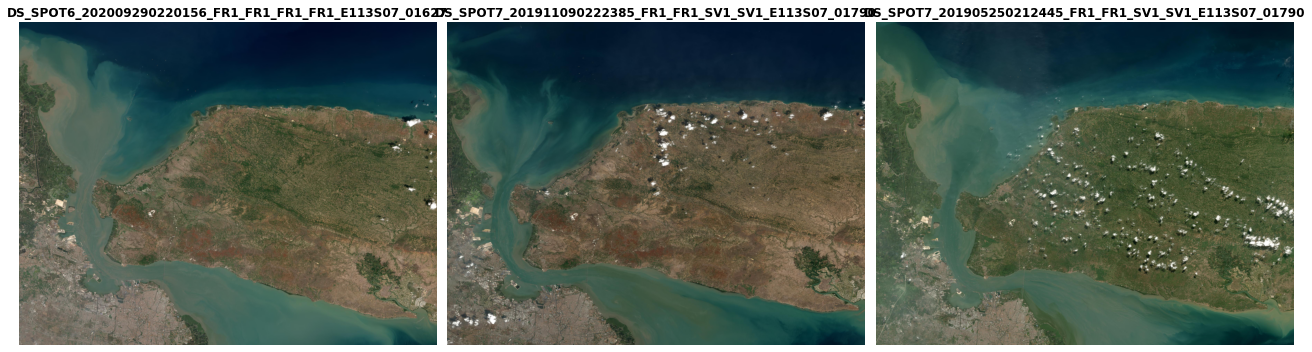


---------GIB---------



100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


,geometry,id,acquisitionDate,constellation,providerName,blockNames,cloudCoverage,up42:usageType,providerProperties,scene_id
0,"POLYGON ((-5.79032 36.97194, -5.78606 35.94822...",d0e3f2d1-446d-4363-a16e-00b7fbf78010,2020-07-10T10:47:55Z,SPOT,oneatlas,"[oneatlas-spot-fullscene, oneatlas-spot-aoicli...",0.0,"[DATA, ANALYTICS]",{'acquisitionDate': '2020-07-10T10:47:55.249Z'...,DS_SPOT7_202007101047552_FR1_FR1_FR1_FR1_W005N...
1,"POLYGON ((-5.77699 36.26248, -5.77327 35.95973...",70c73d86-0e25-4eb8-8967-0a047252262f,2020-03-10T10:29:23Z,SPOT,oneatlas,"[oneatlas-spot-fullscene, oneatlas-spot-aoicli...",0.0,"[DATA, ANALYTICS]","{'acquisitionDate': '2020-03-10T10:29:23Z', 'q...",DS_SPOT6_202003101037200_FR1_FR1_FR1_FR1_W005N...


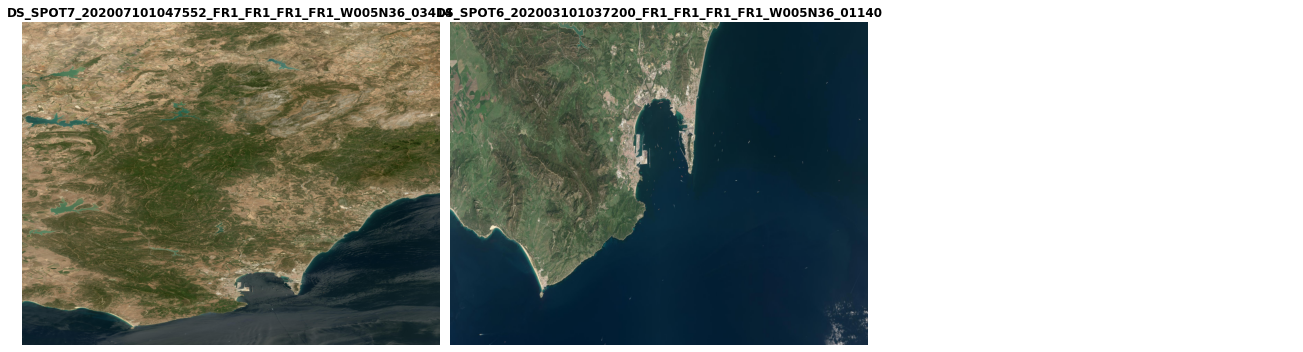

In [212]:
catalog = up42.initialize_catalog()


for aoi in aois:
    print("\n---------" + aoi["title"] + "---------\n")
    search_paramaters = catalog.construct_parameters(geometry=aoi['geometry'], 
                                                     start_date="2019-01-01",
                                                     end_date="2020-12-31",
                                                     sensors=["spot"],
                                                     max_cloudcover=5,
                                                     sortby="acquisitionDate",
                                                     ascending=False,
                                                     limit=3)
    search_results = catalog.search(search_paramaters)
    
    # Download & Visualise quicklooks
    catalog.download_quicklooks(image_ids=search_results.id.to_list(), sensor="spot")
    display(search_results.head())
    catalog.plot_quicklooks(figsize=(18,5), titles=search_results.scene_id.to_list())

    # Select least cloud scene for further workflow
    aoi["scene_id"] = search_results.scene_id.to_list()[0]

In [213]:
# Optional: Select ideal scenes manually
aois[0]["scene_id"] = "DS_SPOT6_202009290220156_FR1_FR1_FR1_FR1_E113S07_01627"
aois[1]["scene_id"] = "DS_SPOT7_202007101047552_FR1_FR1_FR1_FR1_W005N36_03414"

# Run ship identification workflow on selected images

In [214]:
up42.settings(log=True)
project = up42.initialize_project()

# Increase the parallel job limit for the project.
#project.update_project_settings(max_concurrent_jobs=10)

2020-12-02 15:57:21,557 - Initialized Project(name: Dark vessels, project_id: 2db3c170-7772-4bef-9344-2182421e2938, description: Project used for the AIS webinar, createdAt: 2020-11-25T08:08:47.717742Z)


Create or update a workflow for the ship identification

In [215]:
workflow = project.create_workflow("Ship identification", use_existing=True)

2020-12-02 15:57:24,069 - Getting existing workflows in project ...
2020-12-02 15:57:24,413 - Got 2 workflows for project 2db3c170-7772-4bef-9344-2182421e2938.
100%|██████████| 2/2 [00:00<00:00,  2.99it/s]
2020-12-02 15:57:25,086 - Using existing workflow: Ship identification - e9cca692-e320-4b31-aac8-e2b024c474d1


Add or update workflows tasks

In [216]:
input_tasks= ['oneatlas-spot-aoiclipped', 'tiling', 'ship-detection', 'ship-identification']
workflow.add_workflow_tasks(input_tasks=input_tasks)
workflow

2020-12-02 15:57:32,147 - Added tasks to workflow: [{'name': 'oneatlas-spot-aoiclipped:1', 'parentName': None, 'blockId': '045019bb-06fc-4fa1-b703-318725b4d8af'}, {'name': 'tiling:1', 'parentName': 'oneatlas-spot-aoiclipped:1', 'blockId': '3e146dd6-2b67-4d6e-a422-bb3d973e32ff'}, {'name': 'ship-detection:1', 'parentName': 'tiling:1', 'blockId': '79e3e48c-d65f-4528-a6d4-e8d20fecc93c'}, {'name': 'ship-identification:1', 'parentName': 'ship-detection:1', 'blockId': '54217695-73f4-4528-a575-a429e9af6568'}]


Workflow(name: Ship identification, workflow_id: e9cca692-e320-4b31-aac8-e2b024c474d1, description: , createdAt: 2020-11-26T10:12:29.746194Z, project_id: 2db3c170-7772-4bef-9344-2182421e2938, workflow_tasks: {'oneatlas-spot-aoiclipped:1': '2.1.4', 'tiling:1': '2.2.3', 'ship-detection:1': '5.2.0-public', 'ship-identification:1': '2.3.1'}

## Run jobs in parallel

Construct workflow input parameters & run jobs

In [218]:
input_parameters_list = []

for aoi in aois:
    input_parameters = workflow.construct_parameters(geometry=aoi['geometry'], 
                                                     geometry_operation="bbox", 
                                                     scene_ids=[aoi["scene_id"]])
    input_parameters_list.append(input_parameters)

input_parameters_list

[{'oneatlas-spot-aoiclipped:1': {'limit': 1,
   'zoom_level': 17,
   'max_cloud_cover': 100,
   'panchromatic_band': False,
   'ids': ['DS_SPOT6_202009290220156_FR1_FR1_FR1_FR1_E113S07_01627'],
   'bbox': [112.713691, -7.183133, 112.73185, -7.172643]},
  'tiling:1': {'tile_width': 768,
   'tile_height': 768,
   'match_extents': False,
   'output_prefix': '',
   'augmentation_factor': 1,
   'discard_empty_tiles': True},
  'ship-detection:1': {},
  'ship-identification:1': {'minutes': 15}},
 {'oneatlas-spot-aoiclipped:1': {'limit': 1,
   'zoom_level': 17,
   'max_cloud_cover': 100,
   'panchromatic_band': False,
   'ids': ['DS_SPOT7_202007101047552_FR1_FR1_FR1_FR1_W005N36_03414'],
   'bbox': [-5.370973, 36.115663, -5.348018, 36.148606]},
  'tiling:1': {'tile_width': 768,
   'tile_height': 768,
   'match_extents': False,
   'output_prefix': '',
   'augmentation_factor': 1,
   'discard_empty_tiles': True},
  'ship-detection:1': {},
  'ship-identification:1': {'minutes': 15}}]

In [219]:
jobs = workflow.run_jobs_parallel(input_parameters_list=input_parameters_list)

2020-12-02 15:58:33,580 - Selected input_parameters: {'oneatlas-spot-aoiclipped:1': {'limit': 1, 'zoom_level': 17, 'max_cloud_cover': 100, 'panchromatic_band': False, 'ids': ['DS_SPOT6_202009290220156_FR1_FR1_FR1_FR1_E113S07_01627'], 'bbox': [112.713691, -7.183133, 112.73185, -7.172643]}, 'tiling:1': {'tile_width': 768, 'tile_height': 768, 'match_extents': False, 'output_prefix': '', 'augmentation_factor': 1, 'discard_empty_tiles': True}, 'ship-detection:1': {}, 'ship-identification:1': {'minutes': 15}}.
2020-12-02 15:58:35,179 - Created and running new job: 3038736b-e8da-4479-becb-020fee6b9550
2020-12-02 15:58:35,524 - Selected input_parameters: {'oneatlas-spot-aoiclipped:1': {'limit': 1, 'zoom_level': 17, 'max_cloud_cover': 100, 'panchromatic_band': False, 'ids': ['DS_SPOT7_202007101047552_FR1_FR1_FR1_FR1_W005N36_03414'], 'bbox': [-5.370973, 36.115663, -5.348018, 36.148606]}, 'tiling:1': {'tile_width': 768, 'tile_height': 768, 'match_extents': False, 'output_prefix': '', 'augmentatio

# Download & Visualise results

In [221]:
jobtask = job.get_jobtasks()

2020-12-02 16:17:37,130 - Getting job tasks: c67171ab-5f52-4d61-a4c8-d869a540c697


In [222]:
data_results_paths, detection_results, identification_results = [], [], []
for job in jobs:
    data_task, _, detection_task, identification_task = job.get_jobtasks()
    data_paths = data_task.download_results()
    data_results_paths.append([p for p in data_paths if p.endswith(".tif")])    
    detection_results.append(detection_task.get_results_json())
    identification_paths = identification_task.download_results()
    geojson_path = [p for p in identification_paths if p.endswith(".geojson")][0]
    with open(geojson_path) as f:
        gj = geojson.load(f)
    identification_results.append(gj)

2020-12-02 16:18:00,951 - Getting job tasks: 3038736b-e8da-4479-becb-020fee6b9550
2020-12-02 16:18:02,795 - Downloading results of jobtask 04804086-3441-410c-a570-47a4a76e7521
2020-12-02 16:18:02,799 - Download directory: /Users/markus.mueller/projects/up42-py/examples/project_2db3c170-7772-4bef-9344-2182421e2938/job_3038736b-e8da-4479-becb-020fee6b9550/jobtask_04804086-3441-410c-a570-47a4a76e7521
5361it [00:00, 450316.70it/s]
2020-12-02 16:18:04,433 - Download successful of 3 files to output_directory '/Users/markus.mueller/projects/up42-py/examples/project_2db3c170-7772-4bef-9344-2182421e2938/job_3038736b-e8da-4479-becb-020fee6b9550/jobtask_04804086-3441-410c-a570-47a4a76e7521': ['usage.json', 'data.json', '13381019-2a1a-4de5-8c1a-99168bf1918a.tif']
2020-12-02 16:18:05,038 - Retrieved 72 features.
2020-12-02 16:18:05,039 - Downloading results of jobtask 73eb4b61-77c8-4a70-b88f-e95a097f8f64
2020-12-02 16:18:05,041 - Download directory: /Users/markus.mueller/projects/up42-py/examples/p

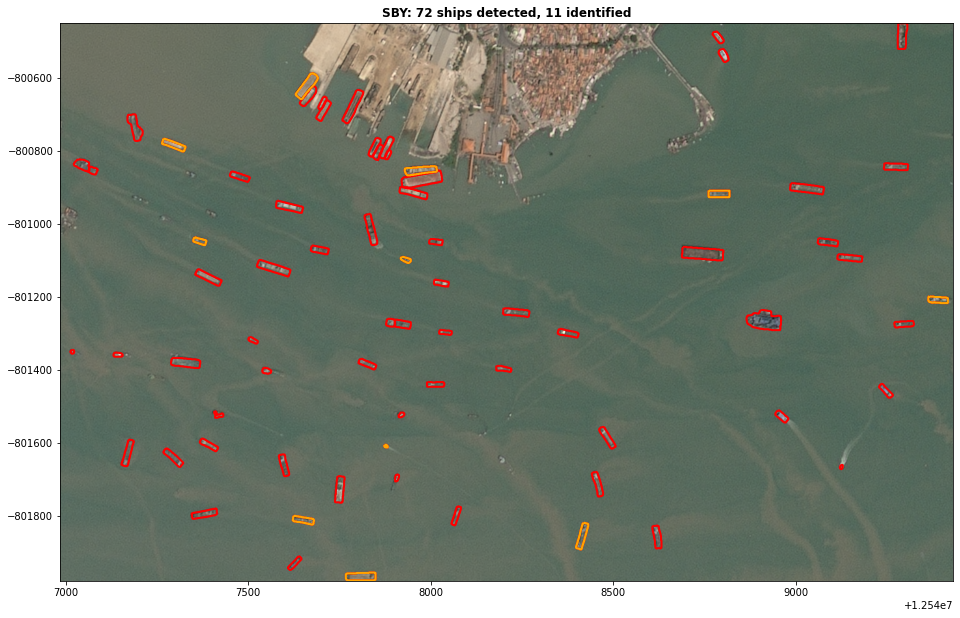

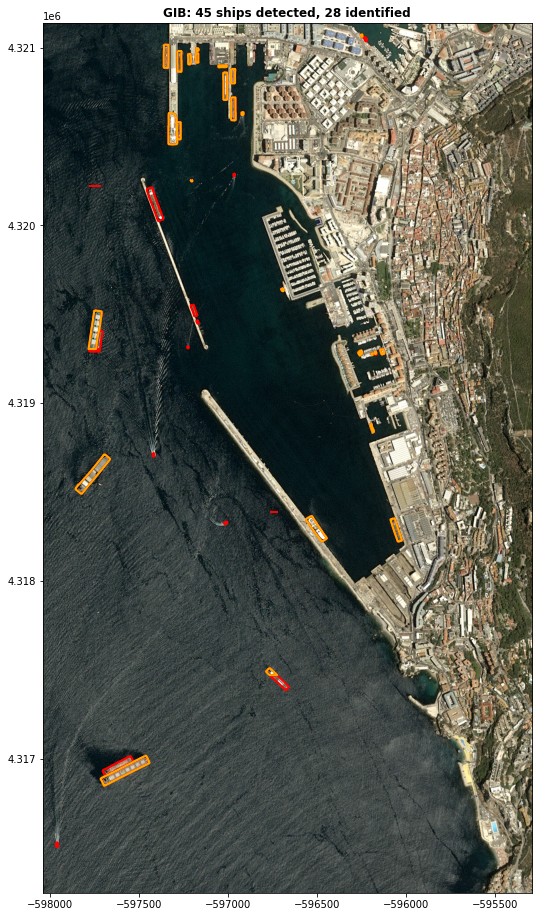

In [227]:
for i, (paths, detection, identification) in enumerate(zip(data_results_paths, detection_results, identification_results)):
    with rasterio.open(paths[0]) as src:
        fig, ax = plt.subplots(figsize=(16, 16))

        ships = gpd.GeoDataFrame.from_features(detection, crs="epsg:4326")
        ships = ships.to_crs(epsg=3857)
        ships_ais = gpd.GeoDataFrame.from_features(identification, crs="urn:ogc:def:crs:OGC:1.3:CRS84")
        ships_ais = ships_ais.to_crs(epsg=3857)
        # Exclude ships without a vessel name
        ships_ais = ships_ais[ships_ais["vessel_name"].notnull()]
   
        ships.plot(ax=ax, facecolor=(0,0,0,0), edgecolor='red', linewidth=2)
        ships_ais.plot(ax=ax, facecolor=(0,0,0,0), edgecolor='orange', linewidth=2)
        
        show(src.read(), transform=src.transform, ax=ax, title=
             f"{aois[i]['title']}: {ships.shape[0]} ships detected, {len(ships_ais.index)} identified")
        
        plt.show()

# Summary

In the above visualisations all ships identified using AIS are shown in orange, while those unidentified in red. This
does not necessarily indicate that those red shops are doing anything illegal; they simply might be too small or the AIS signal could not be found because the time window used for searching is too small. The point is that the red ships are candidate dark vessels - any real-world analysis would need to dive deeper. The analyses are only there to showcase how such an analysis works and we are using the two ports for just that - we don't want to imply at all that someting something fishy is going on there.